# Implementation of a SQP for nonlinear optimal control
The goal of this exercise is to implement a SQP solver to solve a nonlinear optimal control problem.

Consider the pendulum below 

<img src='pendulum.png' width="150">

Assuming $m=l=1$, The dynamics of this pendulum is
$$\ddot{\theta} = u - g \sin\theta$$
which can be discretized with the following dynamics
$$\begin{align}\theta_{n+1} &= \theta_n + \Delta t \omega_n\\ 
\omega_{n+1} &= \omega_n + \Delta t (u_n - g \sin\theta_n)\end{align}$$
where $\theta_n$ is the angle of the pendulum with respect to the vertical at time step $n$ and $\omega_n$ its angular velocity. We will use $\Delta t = 0.01$.
The pendulum starts at configuration $\theta_0 = \omega_0 = 0$, i.e. all the way down with zero velocity and we would like to find
an optimal control that will bring it up to $\theta=\pi$ with zero velocities.

To get the pendulum to do this movement, we write the following optimal control problem
$$\begin{align}
& \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2\\
\textrm{subject to}\ \ & \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$

## Question 1: write a SQP solver to solve this problem
To do so, please follow these steps:
* Write down the algorithm (in words not in code), i.e. write all the steps you need to take
* Write (in Latex) the gradient of the running cost at a given guess $\bar{x} = [\bar{\theta}_0, \bar{\omega}_0, \bar{u}_0, \bar{\theta}_1, \bar{\omega}_1, \bar{u}_1, \dots, \bar{\theta}_{300}, \bar{\omega}_{300}, \bar{u}_{300}]^T$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Write (in Latex) the Hessian of the running cost at a given guess $\bar{x}$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
* Write (in Latex) a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
* Use these functions to construct the inner linear KKT system that you will solve using Numpy's solve function (this should resemble the KKT system you built in the first homework)
* Implement a function that computes the amount of constraint violation, i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
* Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
* Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions $\nabla_x L$ and $\nabla_\lambda L$ are close to 0, e.g. $10^{-4}$.


Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver

### (Simple) filter linear search
Once you have a potential step $p_x$ and associated candidate Lagrange multipliers $p_\lambda$ (from the ``solve`` of the KKT system), you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$ and the Lagrange multipliers $\lambda_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha p_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha p_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha p_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha p_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha p_x$ and the Lagrange multipliers $\lambda_{guess} \leftarrow (1-\alpha)\lambda_{guess} + \alpha p_{lambda}$

In [4]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython

from qpsolvers import solve_qp, Problem, solve_problem

import pendulum

In [5]:
# dt is defined here
print(f'we use the following dt={pendulum.dt}')

# and g here
print(f'we use the following g={pendulum.g}')

# you can use this animate function to display what the pendulum would do for a given sequence of control
N = 300
dt = pendulum.dt
g = pendulum.g
controls = np.zeros((N,1))
x_init = np.array([[1.0],[0.]])
pendulum.animate_robot(x_init, controls.T)

we use the following dt=0.01
we use the following g=9.81


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAUQVtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DyVliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwANdenHSEFz8V9D0Huo6ra97jI0pgHWEgrm6XJ7eYN6T82kB9cDqoIFcQ1W8kYaaar
yB7R9dic4xvVnQpgkTkdJZH7yx7IyIimVgTUYPxFhDkBW+UMQNi3powsubwa8KN+BHTvqeuCVs4q
TK8Sutw9A6fePtWv8tSIuP258+p2cIDR/HoC502qtOvrz43hPJ3RUUchP/jkMpYOAy1Lq6sK90AL
oF/Oz4Y1ENQ0i2f1glYXnTFd9k3tViIdvhb8Obtv7u7iLxCIv9vzQG8cc1UVLjaVsH7rZq4NjwTW
zIbquJdq7N0QwKdYTv0dyhzo4lpN0IKSGmskBpHukKkYODpIi3Vt9jEbjUQiIN79vvT1AmUFW3kV
uJLOParcQoDssxoDtSaQ9lJ/bFa/OrnXXJspTKr+GKYKpYMHoFtBuZJabf0RTNFmbHGicKkwSFLG
3GJ8DhJrbEzxFl6Lc9K4QnQRIAcDrxR9qjwoW5DZnDILQfpVj8xC/OZoMpMmpeKRDqfWMFCjR1sI
3/hyOiIB3xX7wED7Ck154nWEZ3TPA4JgOcmE399kbSPnSNONN0uUJA0KamAETh9wR6FPvxx991l5
JmF0W5xysqdgb0Y3dQv5Ft5N+P/XB+Rm90F73EmjikEYA+v/6bTKQqYFLQ9xueuilsQQ4btK9AAA
AwAAAwAAAwAFRN8tVETrda7twwxRPwJ65LZSBmRudwS5Nr9dzQkmYIjWPpugpyIXXPIapdlKQLIV
BmJaiIB2BnSDmisMTggTqQjpwJkDr0voz3pdlAcfQl782WVgTrWGpLGD6hwIsqDybvx12tZl/8FS
qbOijOECAIn+iqvJ4KWshXyA/4qsDe4dx788S67CoBiMYfcZLaGWECMJ4bAyEuvh/pOeLmTMfsd9
frOdPvTdOEk8XdHnQZiMq2ocfDzuB8eyQRwd/1e7M1uoxkuV1lHXRUFuVM2Ad0lADWo7w9Y4TUgO
Px0dY9q4uDltGCpS/sf8D15AqCPkO//g7liN9dzpl0s11AcNDFYSPMGBK+Zew/7IPg7pniIjZ/WF
WwTkksWIO60w0APXpG+U4tmQdE21bCxo/ToF6mH/62klT56RbEJNeWXefscA9Qb0J/Qul0OTYjjd
PBxi9TnB6mEQCxPfWhI3BwdlSREJ1Nq6W81IcaI9WYAC+IrOMeohADi9HZdwQKoLtupbKeBJNRFC
Ro/8eeTWEyI8YUJEjjoyQwOfv6IEksx+Wm6ZArj+lRUoQieC+OG6IAVmkhaMbEA3Zl2StFtGYXbl
Nbl+DwNBXBJo/PAxt8UKObdT182hzOktc+/EvZ89yBbuDmoXZKjfbEiT+P2bt+O/KPr02NvRmMyT
kFhg2BLYOTKzALafFVOwzURa3fI8WRkftTeFyJ9njwLeRiI/xaaIC7cDdSFqV2TazHkJeaUFSx/v
MQut7HWYfWYbkuM1FRVuEQGRd6eboATF7RemOfirytMQ67g4VtT+0Gj0cHTEe5nmCm7XrNrq0W00
A2TTUM2rHtWiJDilGAUWNhSlmnCA0+eNQ9fSmy6Q0ZevtlmB5a5VBlYsFhRArKxl1wo565awVYR1
DOraME5070tpDspcXX+rrg529gJkG97jxh3CQESCQl2jd06bgNRX6WCjQ8vSvSmb8SNnl/z/ZNeP
yv2vj2bsL5r3FMfdyiE477GvI/xK1Jspe9WTWqFKhcPcaNruMUNFcVozYqclLBdEx1SFp4DzGPgv
gdcNyZOTW4mndtNW2bpNg7vMRsFHwvBIHIp77tUALRVFyY0d9kFBvQXsI5H82zbnBR/qKyyCeKU9
R63dTbhnDctudqNawM8hwl7JnhTQUg9kQGUF1VOAnBcr297kKayH/82zy9S5bslSWd51ZVExEHH9
LgCT+RZcJk91gaiGyKT1MGggBV4BwbyQEOIr2IG4rhoE2xmoL8MCxp2t0OQx09ErywE3jRmdlVVm
Qn8lZpyhmLyOlVP8CcNn/O4JXis5x+OFr8gVrmWCu4wfStdaDR45HKIn+8izUCgw9UT4jcPyRvjr
gmBsr6KeKoIDbbjIX3JVe5d5DC5BX3dnBelwkKZ4aTBzfnfosgsUMe2McljjdLvQeqU1AJQPY1OE
qzDZokNITYMCJsdB8KmqCFYO2X8bgcNdkiGv+Fq3Z/WibfAsycp8zX1ytAJ6Q4mFD1YTLGWFRKUM
DzAgWDu+pFsqEe39b/lk778+upnFKWoZZH8YJMRrfjXa2Q7/Tr8Y5vHXtvhgMYRHyIUePtesqwMb
SrKFWiARQ5Oz+DMXwJQe/MVqxqP+rV/K5+C278j62Fd1iLqPD++9GsPdRd3xE2sXcaR7g0HeLnQc
Z7koCbOAuehO9VH7VTCD+JZtn3lh5aYdVNyQR29lrQ/r2H8aI6igRJCwzdzChrLACVpCSDpAyB6N
aA11hwNn+ckusw3p4hg23WTCRTPbw7bwOgzZ7hG6X+2cSLZN11iFCp8kZvyFyhK7ulqq9/yadkC6
zHse8lQcQH6D40Sy8dt+Y3OhmNHIufAhJ9BPhIV3mjONA16u9JeazNnFFPskyR+WGFaa+VcGHpMB
APJMMZKiu7ek05GhN4q88Wkw19acMg7LNLliwmeM7xKdNWYek3FPyllwdiq3r4ERiCwRIzF3ezdM
uFoiF21I2giPqWce7ead3ldd8j/pEWD/cXO9TwlpL8RPYBKhz0ahyAQmAE8MRCKt0FYLjPRbS7T0
BdoMdM3FPddL1/GA0E1A60lGMq4gIzCV5w4OCcy4uyisCE+tqtGzZrIXIVcuf3Z3j1ktWQXQs9/K
A5v98vNc7O/SO5E7e3wk7

In [6]:
# Initialization of the x_guess and controls for the pendulum
def initialize_sqp(N):
    controls = np.zeros((N, 1))  
    x_init = np.array([[1.0], [0.]]) 
    
    x_guess = np.zeros(3 * (N + 1))  
    x_guess[0] = x_init[0, 0]  
    x_guess[1] = x_init[1, 0]  

    return x_guess, controls

x_guess, controls = initialize_sqp(N)

In [7]:
# Cost function and its derivatives
def cost(x):
    theta, omega, u = x.reshape(-1, 3).T
    return np.sum(10 * (theta - np.pi)**2 + 0.1 * omega**2 + 0.1 * u**2)

def cost_gradient(x):
    theta, omega, u = x.reshape(-1, 3).T
    grad = np.zeros_like(x)
    grad[::3] = 20 * (theta - np.pi)
    grad[1::3] = 0.2 * omega
    grad[2::3] = 0.2 * u
    return grad

def cost_hessian(x):
    hess = np.zeros((len(x), len(x)))
    np.fill_diagonal(hess[::3, ::3], 20)
    np.fill_diagonal(hess[1::3, 1::3], 0.2)
    np.fill_diagonal(hess[2::3, 2::3], 0.2)
    return hess

In [8]:
# Constraint functions and their derivatives
def constraints(x):
    theta, omega, u = x.reshape(-1, 3).T
    c = np.zeros(2 * N)
    c[::2] = theta[1:] - theta[:-1] - dt * omega[:-1]
    c[1::2] = omega[1:] - omega[:-1] - dt * (u[:-1] - g * np.sin(theta[:-1]))
    return c

def constraint_jacobian(x):
    theta = x[::3]
    G = np.zeros((2 * N, len(x)))
    
    for i in range(N):
        G[2*i, 3*i] = -1
        G[2*i, 3*i+1] = -dt
        G[2*i, 3*(i+1)] = 1
        
        G[2*i+1, 3*i] = dt * g * np.cos(theta[i])
        G[2*i+1, 3*i+1] = -1
        G[2*i+1, 3*i+2] = -dt
        G[2*i+1, 3*(i+1)+1] = 1
    
    return G

def constraint_rhs(x):
    return -constraints(x)

In [34]:
# SQP Solver Implementation
def sqp_solver(x_guess, max_iter=100, tol=1e-4):
    x = x_guess.copy()
    lambda_ = np.zeros(2 * N) 
    
    f_best = np.inf
    c_best = np.inf
    
    costs = []
    violations = []
    alphas = []
    
    for iteration in range(max_iter):
        grad_f = cost_gradient(x)
        hess_f = cost_hessian(x)
        G = constraint_jacobian(x)
        g = constraint_rhs(x)
        
        KKT_matrix = np.block([
            [hess_f, G.T],
            [G, np.zeros((G.shape[0], G.shape[0]))]
        ])
        
        rhs_vector = np.concatenate([-grad_f - G.T @ lambda_, -g])
        
        sol = np.linalg.solve(KKT_matrix, rhs_vector)
        p_x, p_lambda = sol[:len(x)], sol[len(x):]
        
        alpha = filter_line_search(x, lambda_, p_x, p_lambda, f_best, c_best)
        
        x += alpha * p_x
        lambda_ += alpha * (p_lambda - lambda_)
        
        f_current = cost(x)
        c_current = np.sum(np.abs(constraints(x)))
        
        f_best = min(f_best, f_current)
        c_best = min(c_best, c_current)
        
        costs.append(f_current)
        violations.append(c_current)
        alphas.append(alpha)
        
        kkt_violation = np.max(np.abs(np.concatenate([grad_f + G.T @ lambda_, g])))
        
        if kkt_violation < tol:
            break
    
    return x, costs, violations, alphas

In [35]:
#filter line search for the SQP solver for the pendulum
def filter_line_search(x, lambda_, p_x, p_lambda, f_best, c_best, gamma=0.1, rho=0.5, beta=0.9, max_iter=500):
    alpha = 1.0  
    f_new = cost(x + alpha * p_x)
    c_new = np.sum(np.abs(constraints(x + alpha * p_x)))

    # Initialization of filter with best values so far
    filter_list = [(f_best, c_best)]
    
    for _ in range(max_iter):
        # If the new point improves either cost or constraint violation sufficiently
        if f_new < f_best - gamma * alpha * np.linalg.norm(p_x)**2 or c_new < c_best:
            return alpha
        
        alpha *= rho

        f_new = cost(x + alpha * p_x)
        c_new = np.sum(np.abs(constraints(x + alpha * p_x)))

        filter_dominated = False
        for f_filter, c_filter in filter_list:
            if f_new >= f_filter and c_new >= c_filter:
                filter_dominated = True
                break
        
        if not filter_dominated:
            filter_list.append((f_new, c_new))

    return alpha

In [36]:
# Solution of the pendulum using the sqp_solver
x_sol, costs, violations, alphas = sqp_solver(x_guess)

theta_sol, omega_sol, u_sol = x_sol.reshape(-1, 3).T
t_values = np.arange(N + 1) * dt
print(x_sol)

[  5.06488378  10.10308173   0.08187705   1.1659146   10.27942374
   0.18518038   1.26870884  10.15663669   0.30584454   1.37027521
  10.02516931   0.4427263    1.4705269    9.88552187   0.59470893
   1.56938212   9.73819687   0.76070561   1.66676409   9.58369566
   0.93966236   1.76260104   9.42251542   1.13056056   1.8568262
   9.25514653   1.33241893   1.94937766   9.08207013   1.54429515
   2.04019836   8.90375612   1.76528703   2.12923592   8.72066152
   1.99453322   2.21644254   8.53322916   2.23121366   2.30177483
   8.34188666   2.47454958   2.3851937    8.14704578   2.72380335
   2.46666416   7.94910201   2.97827788   2.54615518   7.74843446
   3.237316     2.62363952   7.54540587   3.5002995    2.69909358
   7.34036295   3.76664811   2.77249721   7.13363674   4.0358183
   2.84383358   6.92554314   4.30730207   2.91308901   6.71638358
   4.58062556   2.98025284   6.50644568   4.85534779   3.0453173
   6.29600398   5.1310592    3.10827734   6.08532067   5.40738032
   3.16913055

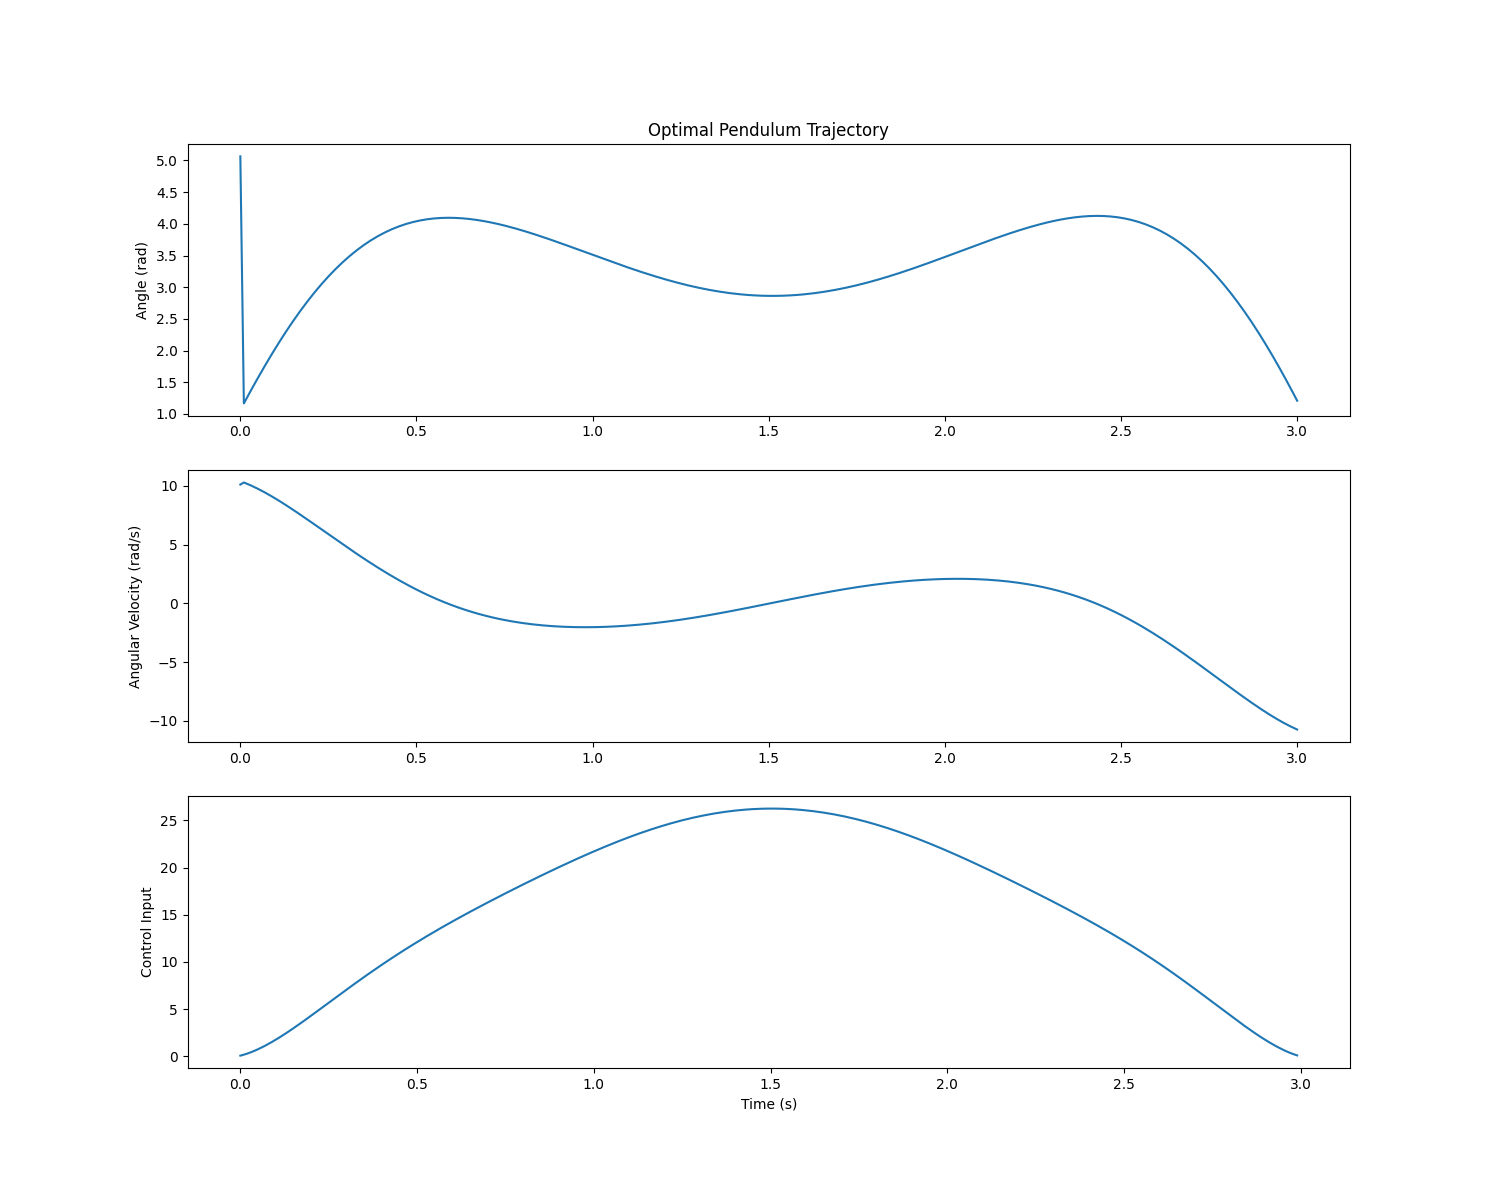

In [37]:
plt.figure(figsize=(15, 12))
plt.subplot(311)
plt.plot(t_values, theta_sol)
plt.ylabel('Angle (rad)')
plt.title('Optimal Pendulum Trajectory')

plt.subplot(312)
plt.plot(t_values, omega_sol)
plt.ylabel('Angular Velocity (rad/s)')

plt.subplot(313)
plt.plot(t_values[:-1], u_sol[:-1])
plt.ylabel('Control Input')
plt.xlabel('Time (s)')

plt.show()

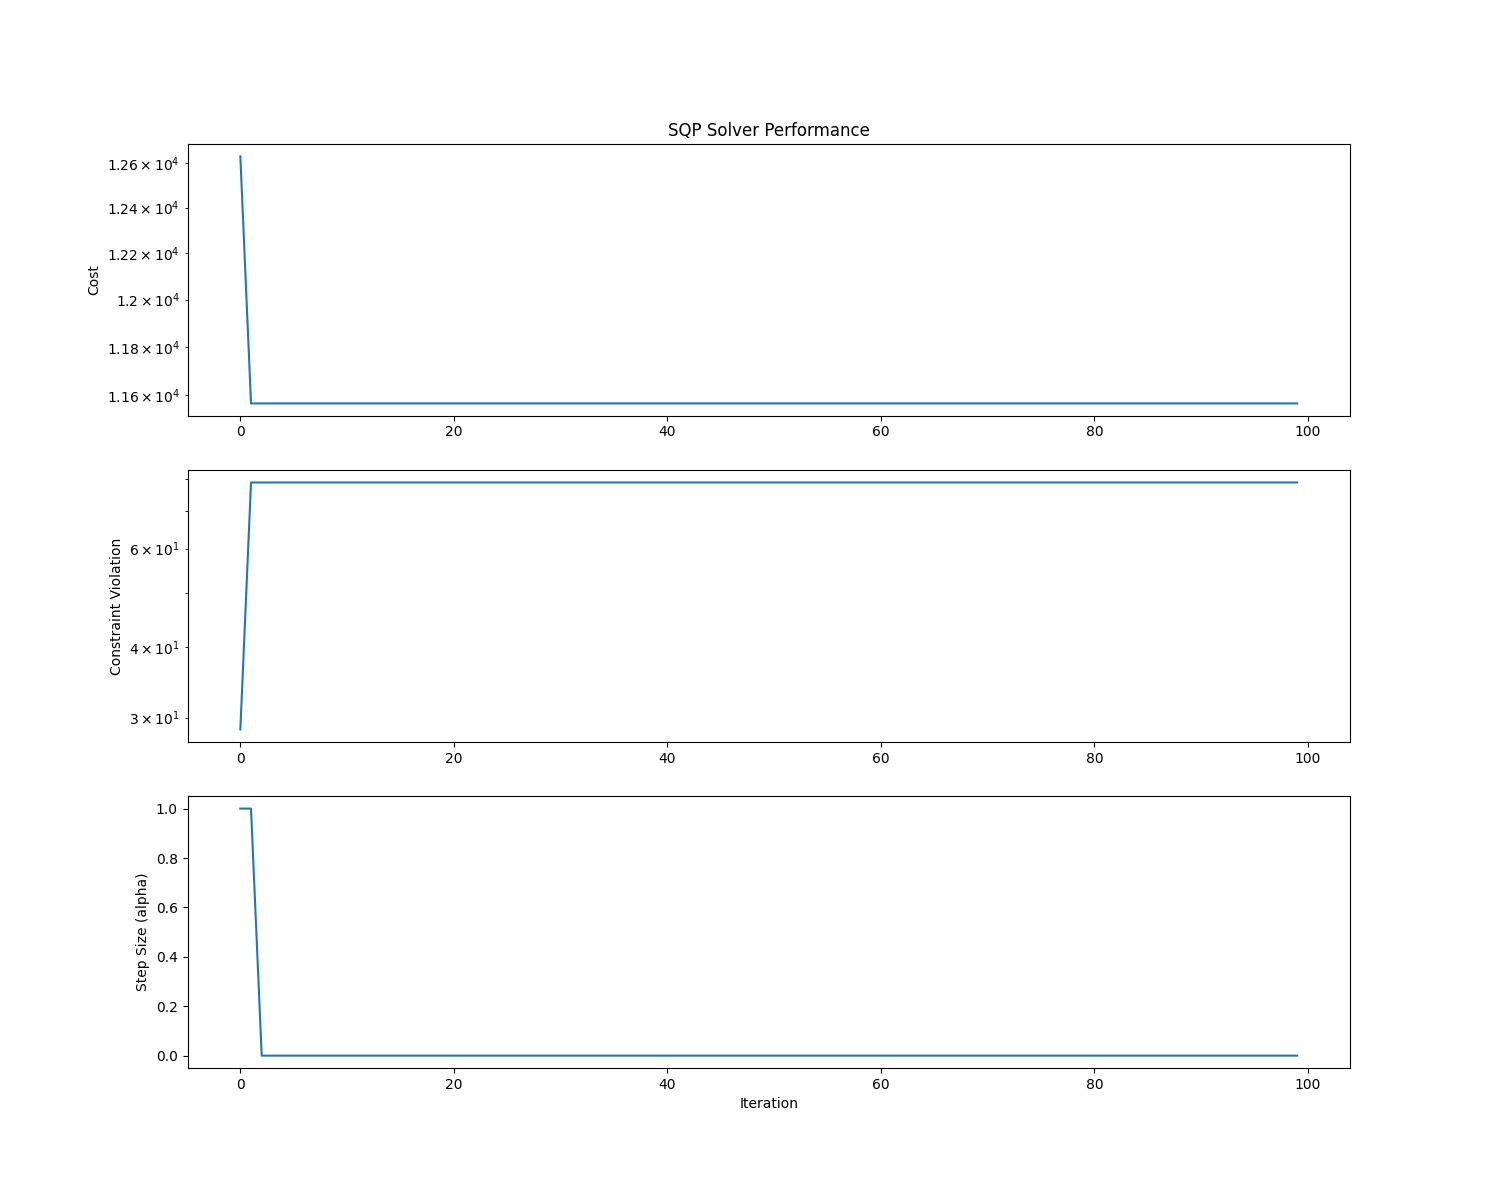

Number of iterations: 100


In [38]:
# Plot iteration data
plt.figure(figsize=(15, 12))
plt.subplot(311)
plt.semilogy(costs)
plt.ylabel('Cost')
plt.title('SQP Solver Performance')

plt.subplot(312)
plt.semilogy(violations)
plt.ylabel('Constraint Violation')

plt.subplot(313)
plt.plot(alphas)
plt.ylabel('Step Size (alpha)')
plt.xlabel('Iteration')

plt.show()

print(f"Number of iterations: {len(costs)}")

## Question 2: write a SQP solver with inequality constraints
Modify your SQP solver in order to enforce the additional constraint $-4 \leq u_n \leq 4$. 

In this case you will need to use a QP solver instead of the ``solve`` function. Please use the [qpsolvers](https://pypi.org/project/qpsolvers/) library (use ``pip install qpsolvers`` to get the latest version 4.4.0 and use ``cvxopt`` as QP solver). You may access the Lagrange multipliers of the solution following [this example](https://qpsolvers.github.io/qpsolvers/quadratic-programming.html#dual-multipliers).

Update the convergence checks accordingly (using the KKT condition for the nonlinear problem $\nabla_x L$). Also update the computation of the constraint violation by computing the amount of inequality constraint violation in absolute value (note that it should be zero when the constraint is satisfied).

Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver
6. Compare this solution with the solution from Question 1. Are there any qualitative differences in the pendulum behavior? Did the solver converge faster or slower?

In [39]:
# Initialization of SQP solver variables
def initialize_sqp(N):
    x_init = np.array([[1.0], [0.0]])  
    x_guess = np.zeros(3 * (N + 1))    
    x_guess[0], x_guess[1] = x_init[0, 0], x_init[1, 0] 
    return x_guess

x_guess = initialize_sqp(N)

In [40]:
# Definition of cost, gradient, and Hessian functions
def cost(x):
    theta, omega, u = x.reshape(-1, 3).T
    return np.sum(10 * (theta - np.pi) ** 2 + 0.1 * omega ** 2 + 0.1 * u ** 2)

def cost_gradient(x):
    theta, omega, u = x.reshape(-1, 3).T
    grad = np.zeros_like(x)
    grad[::3] = 20 * (theta - np.pi)
    grad[1::3] = 0.2 * omega
    grad[2::3] = 0.2 * u
    return grad

def cost_hessian(x):
    hess = np.zeros((len(x), len(x)))
    np.fill_diagonal(hess[::3, ::3], 20)
    np.fill_diagonal(hess[1::3, 1::3], 0.2)
    np.fill_diagonal(hess[2::3, 2::3], 0.2)
    return hess

In [41]:
# Definition of the constraints and Jacobian functions
def constraints(x):
    theta, omega, u = x.reshape(-1, 3).T
    c = np.zeros(2 * N)
    c[::2] = theta[1:] - theta[:-1] - dt * omega[:-1]
    c[1::2] = omega[1:] - omega[:-1] - dt * (u[:-1] - g * np.sin(theta[:-1]))
    return c

def constraint_jacobian(x):
    theta = x[::3]
    G = np.zeros((2 * N, len(x)))
    for i in range(N):
        G[2 * i, 3 * i] = -1
        G[2 * i, 3 * i + 1] = -dt
        G[2 * i, 3 * (i + 1)] = 1
        G[2 * i + 1, 3 * i] = dt * g * np.cos(theta[i])
        G[2 * i + 1, 3 * i + 1] = -1
        G[2 * i + 1, 3 * i + 2] = -dt
        G[2 * i + 1, 3 * (i + 1) + 1] = 1
    return G

def inequality_constraints(N):
    # G and h matrices for inequality constraints -4 <= u_n <= 4
    G = np.zeros((2 * N, 3 * (N + 1)))
    h = np.zeros(2 * N)
    
    for i in range(N):
        G[2 * i, 3 * i + 2] = -1  
        h[2 * i] = 4
        
        G[2 * i + 1, 3 * i + 2] = 1  
        h[2 * i + 1] = 4

    return G, h

In [42]:
# Filter Line Search for step-size determination
def filter_line_search(x, lambda_, p_x, f_best, c_best, rho=0.5):
    alpha = 1.0
    while True:
        x_new = x + alpha * p_x
        f_new = cost(x_new)
        c_new = np.sum(np.abs(constraints(x_new)))
        
        # If new cost or constraints are better
        if f_new < f_best or c_new < c_best:
            return alpha
        
        alpha *= rho  

In [43]:
# Solution using SQP with QP solver and inequality constraints
def sqp_solver(x_guess, max_iter=500, tol=1e-4):
    x = x_guess.copy()
    lambda_ = np.zeros(2 * N)
    
    costs, violations, alphas = [], [], []
    
    f_best, c_best = np.inf, np.inf  
    
    for iteration in range(max_iter):
        grad_f = cost_gradient(x)
        hess_f = cost_hessian(x)
        G_eq = constraint_jacobian(x)
        g_eq = constraints(x)
        
        G_ineq, h_ineq = inequality_constraints(N)
        
        p = solve_qp(hess_f, grad_f, G=G_ineq, h=h_ineq, A=G_eq, b=-g_eq, solver='cvxopt')
        
        alpha = filter_line_search(x, lambda_, p, f_best, c_best)
        x += alpha * p
        
        f_best = min(f_best, cost(x))
        c_best = min(c_best, np.sum(np.abs(constraints(x))))
        
        costs.append(cost(x))
        violations.append(np.sum(np.abs(constraints(x))))
        alphas.append(alpha)
        
        if np.linalg.norm(p) < tol:
            break
    
    return x, costs, violations, alphas

In [44]:
# Solution of the problem
x_sol, costs, violations, alphas = sqp_solver(x_guess)

theta_sol, omega_sol, u_sol = x_sol.reshape(-1, 3).T
t = np.arange(N + 1) * dt
print(x_sol)

[ 3.14159265e+00  5.14466399e-16  5.80100129e-18  3.14159265e+00
  4.96092975e-16  1.20320654e-17  3.14159265e+00  4.78286553e-16
  1.86557748e-17  3.14159265e+00  4.61033036e-16  2.56367003e-17
  3.14159265e+00  4.44318527e-16  3.29413159e-17  3.14159265e+00
  4.28129338e-16  4.05379168e-17  3.14159265e+00  4.12451992e-16
  4.83965375e-17  3.14159265e+00  3.97273226e-16  5.64888775e-17
  3.14159265e+00  3.82579999e-16  6.47882244e-17  3.14159265e+00
  3.68359491e-16  7.32693854e-17  3.14159265e+00  3.54599105e-16
  8.19086197e-17  3.14159265e+00  3.41286473e-16  9.06835707e-17
  3.14159265e+00  3.28409451e-16  9.95732009e-17  3.14159265e+00
  3.15956128e-16  1.08557739e-16  3.14159265e+00  3.03914820e-16
  1.17618612e-16  3.14159265e+00  2.92274073e-16  1.26738395e-16
  3.14159265e+00  2.81022665e-16  1.35900759e-16  3.14159265e+00
  2.70149602e-16  1.45090413e-16  3.14159265e+00  2.59644117e-16
  1.54293060e-16  3.14159265e+00  2.49495676e-16  1.63495348e-16
  3.14159265e+00  2.39693

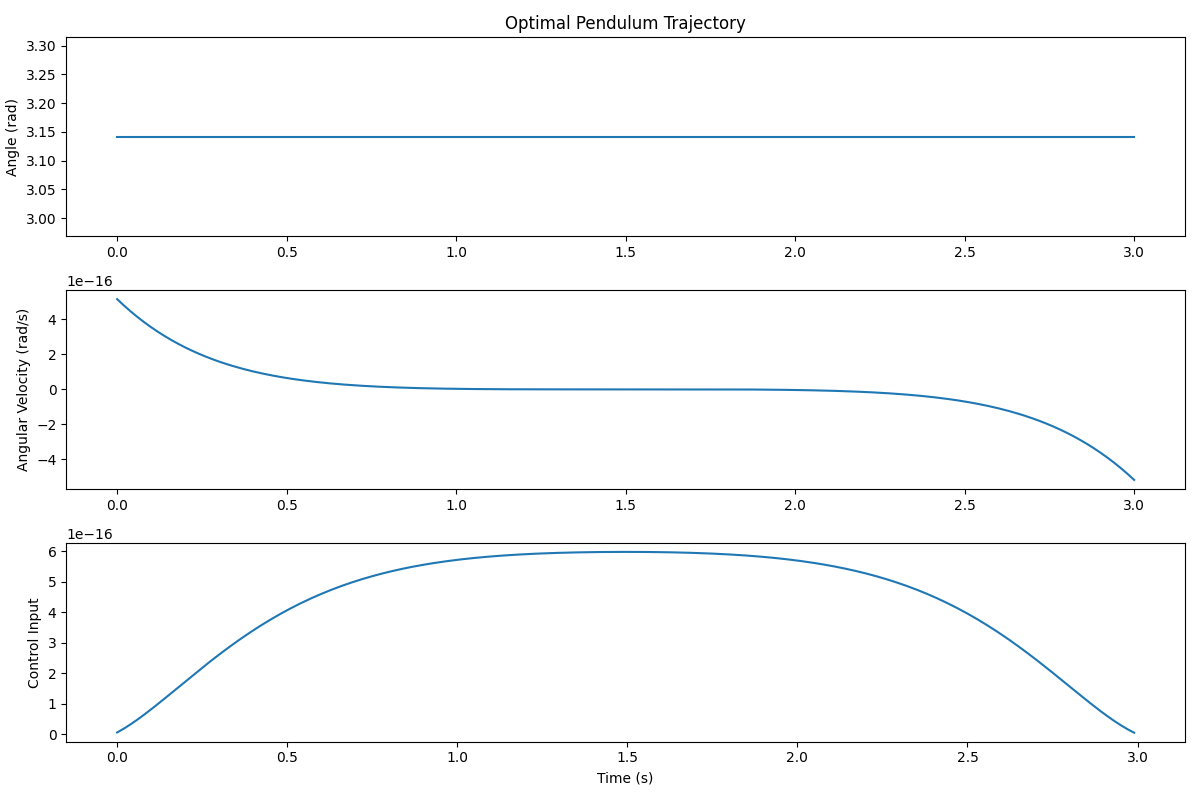

In [45]:
# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(t, theta_sol)
plt.ylabel('Angle (rad)')
plt.title('Optimal Pendulum Trajectory')

plt.subplot(312)
plt.plot(t, omega_sol)
plt.ylabel('Angular Velocity (rad/s)')

plt.subplot(313)
plt.plot(t[:-1], u_sol[:-1])
plt.ylabel('Control Input')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

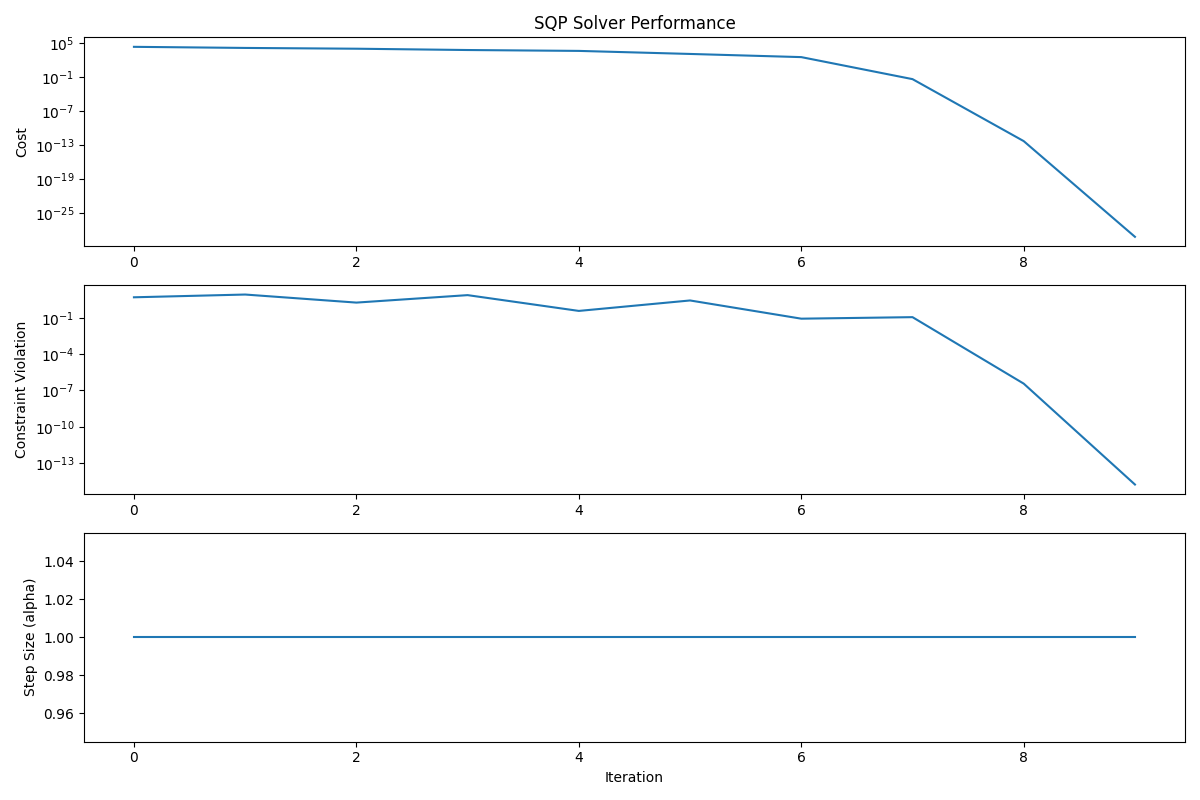

In [46]:
# Plot solver performance
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.semilogy(costs)
plt.ylabel('Cost')
plt.title('SQP Solver Performance')

plt.subplot(312)
plt.semilogy(violations)
plt.ylabel('Constraint Violation')

plt.subplot(313)
plt.plot(alphas)
plt.ylabel('Step Size (alpha)')
plt.xlabel('Iteration')

plt.tight_layout()
plt.show()